## Part 0: Packages
### Not all of the following packages are required

In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import igraph
import scvelo as scv
import loompy as lmp
import anndata
from scipy import io
from scipy.io import mmread
from scipy.sparse import csr_matrix, coo_matrix
import scanorama
import os

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


## Part 1: QC and Samples Preparation

### Louie et. al Samples Upload

In [3]:
louie_folder = "/Users/mohammedkhattab/Downloads/CART_GitHub/Data/Preinfusion_l"
louie_samples = []

# Get the first three folders
sample_folders = os.listdir(louie_folder)[:3]

for louie_sample_folder in sample_folders:
    #for file in sample_folder:
    matrix_path1 = os.path.join(louie_folder,louie_sample_folder,"matrix.mtx")
    matrix1 = mmread(matrix_path1).tocsc()
    genes_path1 = os.path.join(louie_folder,louie_sample_folder,"genes.tsv") 
    barcodes_path1 = os.path.join(louie_folder,louie_sample_folder,"barcodes.tsv") 
    genes_df1 = pd.read_csv(genes_path1, header=None, sep="\t")
    barcodes_df1 = pd.read_csv(barcodes_path1, header=None, sep="\t")
    
    l1 = sc.AnnData(X=matrix1.T)
    l1.var['gene_symbols'] = genes_df1[0].values
    l1.obs['barcodes'] = barcodes_df1[0].values
    l1.var_names = l1.var['gene_symbols']
    l1.obs.set_index("barcodes", inplace=True)
    l1.var_names_make_unique()
    sc.pp.filter_cells(l1, min_genes= 200)
    sc.pp.filter_genes(l1, min_cells= 3)
    l1.var["mt"] = l1.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(l1, qc_vars= ["mt"], percent_top= None, log1p= False, inplace= True)
    l1 = l1[l1.obs.n_genes_by_counts < 5000, :]
    l1 = l1[l1.obs.total_counts < 20000, :]
    l1 = l1[l1.obs.pct_counts_mt < 10, :]
    l1.var = l1.var.rename_axis("index")
    l1.obs['sample'] = louie_sample_folder
    l1
    louie_samples.append(l1)

filtered out 23 cells that have less than 200 genes expressed
filtered out 16505 genes that are detected in less than 3 cells
filtered out 6 cells that have less than 200 genes expressed
filtered out 16183 genes that are detected in less than 3 cells
filtered out 11 cells that have less than 200 genes expressed
filtered out 16124 genes that are detected in less than 3 cells


In [4]:
len(louie_samples)

3

### Haradhvala et. al Samples Upload

In [5]:
haradhvala_folder = "/Users/mohammedkhattab/Downloads/CART_GitHub/Data/Preinfusion_h"
haradhvala_samples = []

sample_folders = os.listdir(haradhvala_folder)[:3]

for sample_folder in sample_folders:
    #for file in sample_folder:
        h1 = sc.read_10x_mtx(os.path.join(haradhvala_folder,sample_folder), var_names= "gene_symbols", cache= True)
        h1.var_names_make_unique()
        sc.pp.filter_cells(h1, min_genes= 200)
        sc.pp.filter_genes(h1, min_cells= 3)
        h1.var["mt"] = h1.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(h1, qc_vars= ["mt"], percent_top= None, log1p= False, inplace= True)
        h1 = h1[h1.obs.n_genes_by_counts < 5000, :]
        h1 = h1[h1.obs.total_counts < 20000, :]
        h1 = h1[h1.obs.pct_counts_mt < 10, :]
        h1.obs['sample'] = sample_folder
        haradhvala_samples.append(h1)

... reading from cache file cache/Users-mohammedkhattab-Downloads-CART_GitHub-Data-Preinfusion_h-Patient22-Baseline-matrix.h5ad
filtered out 103 cells that have less than 200 genes expressed
filtered out 43199 genes that are detected in less than 3 cells
... reading from cache file cache/Users-mohammedkhattab-Downloads-CART_GitHub-Data-Preinfusion_h-Patient23-Baseline-matrix.h5ad
filtered out 1841 cells that have less than 200 genes expressed
filtered out 44451 genes that are detected in less than 3 cells
... reading from cache file cache/Users-mohammedkhattab-Downloads-CART_GitHub-Data-Preinfusion_h-Patient17-Baseline-matrix.h5ad
filtered out 347 cells that have less than 200 genes expressed
filtered out 44260 genes that are detected in less than 3 cells


In [6]:
len(haradhvala_samples)

3

In [7]:
haradhvala_samples[2].obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample
AAACCTGAGATATACG-1-7,1136,1132,2144.0,174.0,8.115671,Patient17-Baseline
AAACCTGAGTGCTGCC-1-7,963,963,1827.0,41.0,2.244116,Patient17-Baseline
AAACCTGCAATGAAAC-1-7,2534,2532,6817.0,318.0,4.664808,Patient17-Baseline
AAACCTGCACACAGAG-1-7,1149,1148,2288.0,46.0,2.010489,Patient17-Baseline
AAACCTGCACCGAAAG-1-7,1263,1263,2708.0,105.0,3.877400,Patient17-Baseline


## Part 2: merge Anndata

In [8]:
merged_list = haradhvala_samples + louie_samples #merge the two lists

In [9]:
len(merged_list)

6

In [10]:
merged_adata = sc.concat(merged_list)

In [11]:
merged_adata.obs.head() #shape (120288, 6)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample
AAACCTGAGAAAGTGG-1-7,486,486,2889.0,179.0,6.195916,Patient22-Baseline
AAACCTGAGATCTGCT-1-7,982,982,1946.0,88.0,4.522097,Patient22-Baseline
AAACCTGAGCCAGTTT-1-7,664,664,1428.0,61.0,4.271709,Patient22-Baseline
AAACCTGAGGTGTGGT-1-7,847,847,1695.0,144.0,8.495575,Patient22-Baseline
AAACCTGCAAGGTTCT-1-7,690,689,1320.0,42.0,3.181818,Patient22-Baseline


In [12]:
merged_adata.shape

(46611, 12783)

In [13]:
merged_adata.var_names_make_unique()

In [14]:
sc.pp.filter_cells(merged_adata, min_genes= 200)
sc.pp.filter_genes(merged_adata, min_cells= 5)

filtered out 138 cells that have less than 200 genes expressed


In [15]:
merged_adata.obs.shape

(46473, 6)

In [16]:
merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(merged_adata, qc_vars= ["mt"], percent_top= None, log1p= False, inplace= True)

In [17]:
merged_adata.obs.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample
AAACCTGAGAAAGTGG-1-7,458,458,2729.0,90.0,3.297911,Patient22-Baseline
AAACCTGAGATCTGCT-1-7,947,947,1879.0,67.0,3.565726,Patient22-Baseline


In [18]:
merged_adata = merged_adata[merged_adata.obs.n_genes_by_counts < 5000, :]
merged_adata = merged_adata[merged_adata.obs.total_counts < 20000, :]
merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 10, :]

In [19]:
merged_adata.obs.shape

(44150, 6)

### Highly expressed Genes

normalizing counts per cell
    finished (0:00:00)


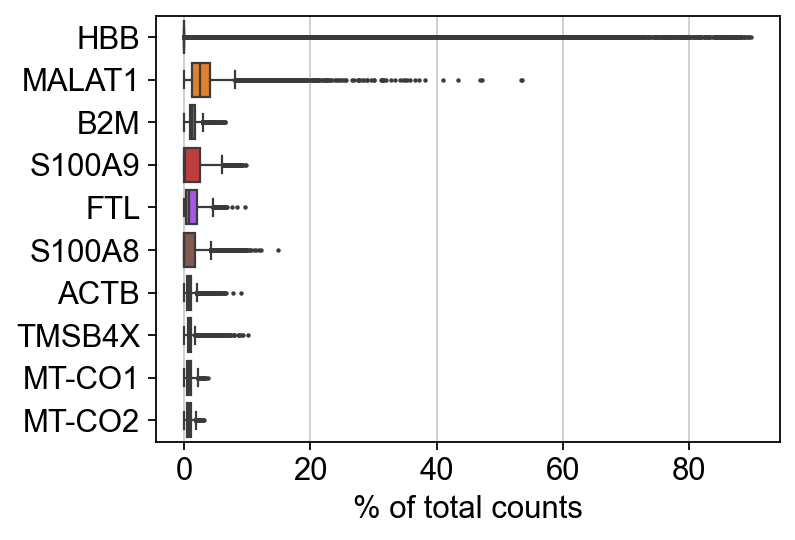

In [20]:
sc.pl.highest_expr_genes(merged_adata,n_top= 10)

In [21]:
sc.pp.normalize_total(merged_adata, target_sum= 1e4)
sc.pp.log1p(merged_adata)
sc.pp.highly_variable_genes(merged_adata,min_mean= 0.0125, max_mean= 3, min_disp= 0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


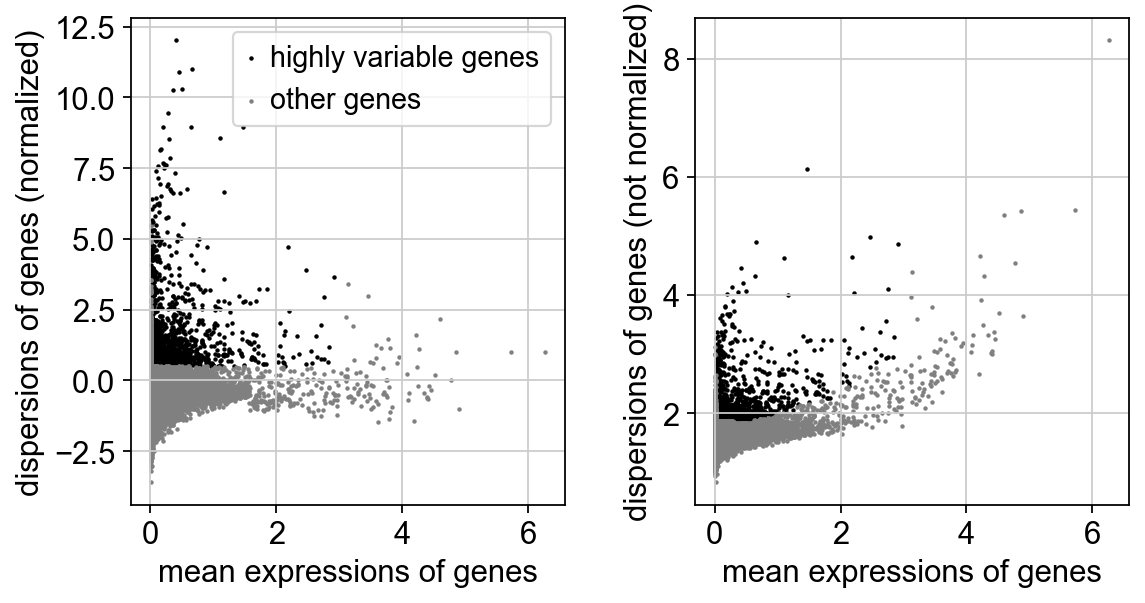

In [22]:
sc.pl.highly_variable_genes(merged_adata)

In [23]:
merged_adata.raw = merged_adata
merged_adata.var.shape

(12783, 10)

In [24]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]
merged_adata.var.shape

(2181, 10)

## Part 3: Dimensionality Reduction and Plotting

In [25]:
sc.pp.regress_out(merged_adata,["total_counts","pct_counts_mt"])
sc.pp.scale(merged_adata, max_value= 10)
sc.tl.pca(merged_adata, svd_solver= "arpack")

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:54)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:44)


### PCA plot Labelled by CD4 and CD8A expression

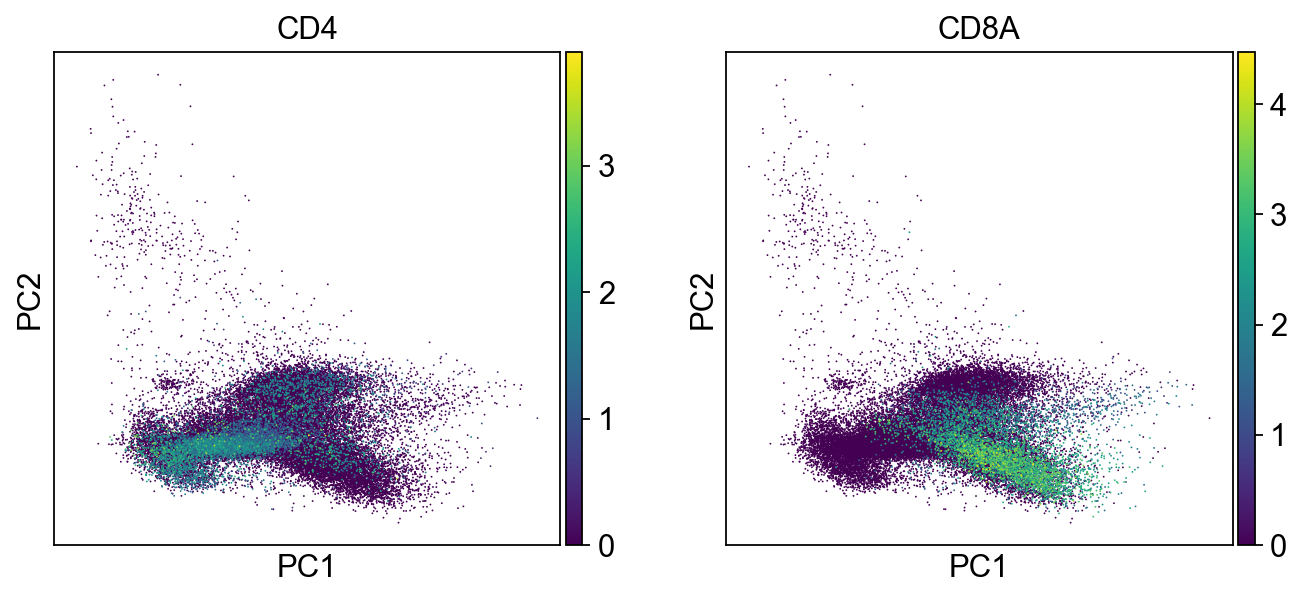

In [26]:
sc.pl.pca(merged_adata,color = ["CD4", "CD8A"])

### Clustering using Louvain Algorithm at reolution 0.7

In [31]:
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)
sc.tl.louvain(merged_adata, resolution=0.7)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)


In [35]:
merged_adata

AnnData object with n_obs × n_vars = 44150 × 2181
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'louvain'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Unintegrated cell clusters, labelled by Louvain (on the left) and labelled by different samples (on the right)

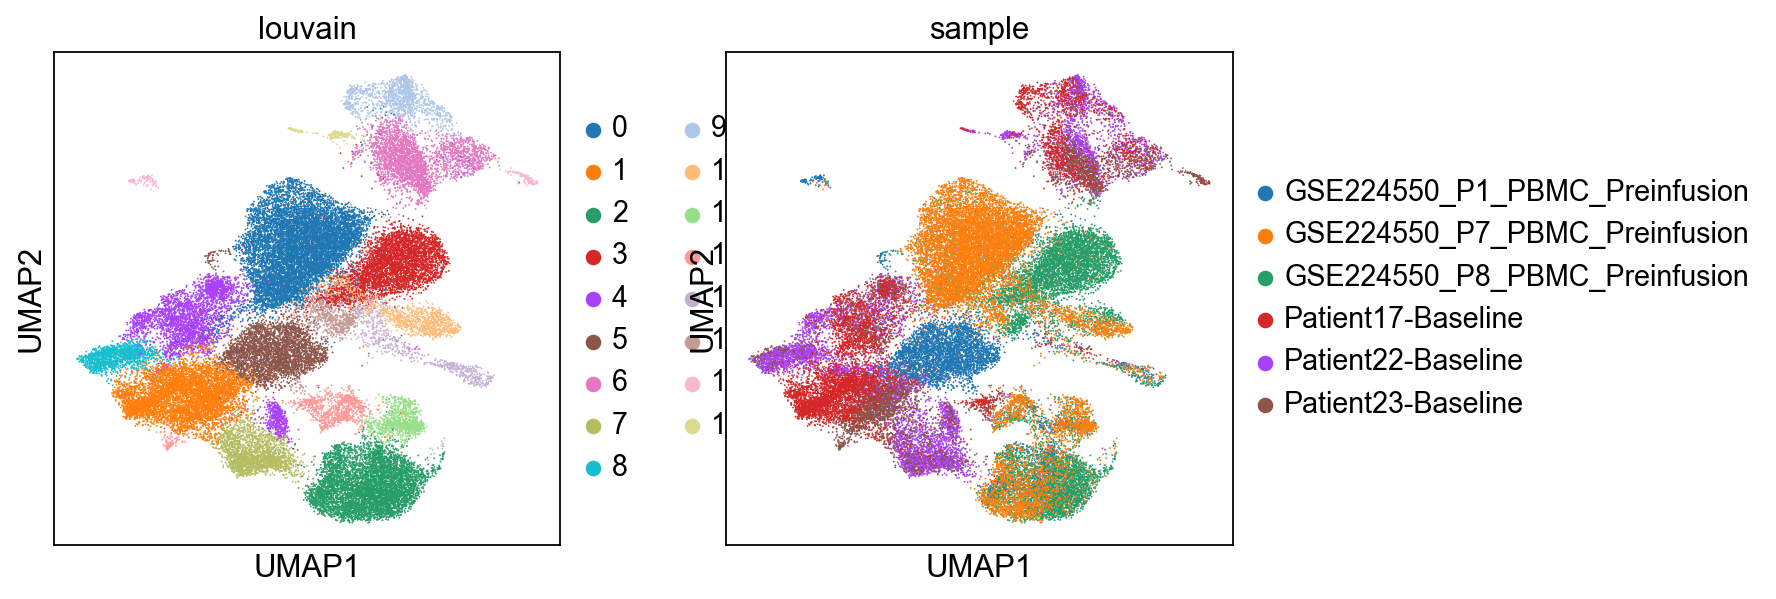

In [36]:
sc.pl.umap(merged_adata,color= ["louvain","sample"])

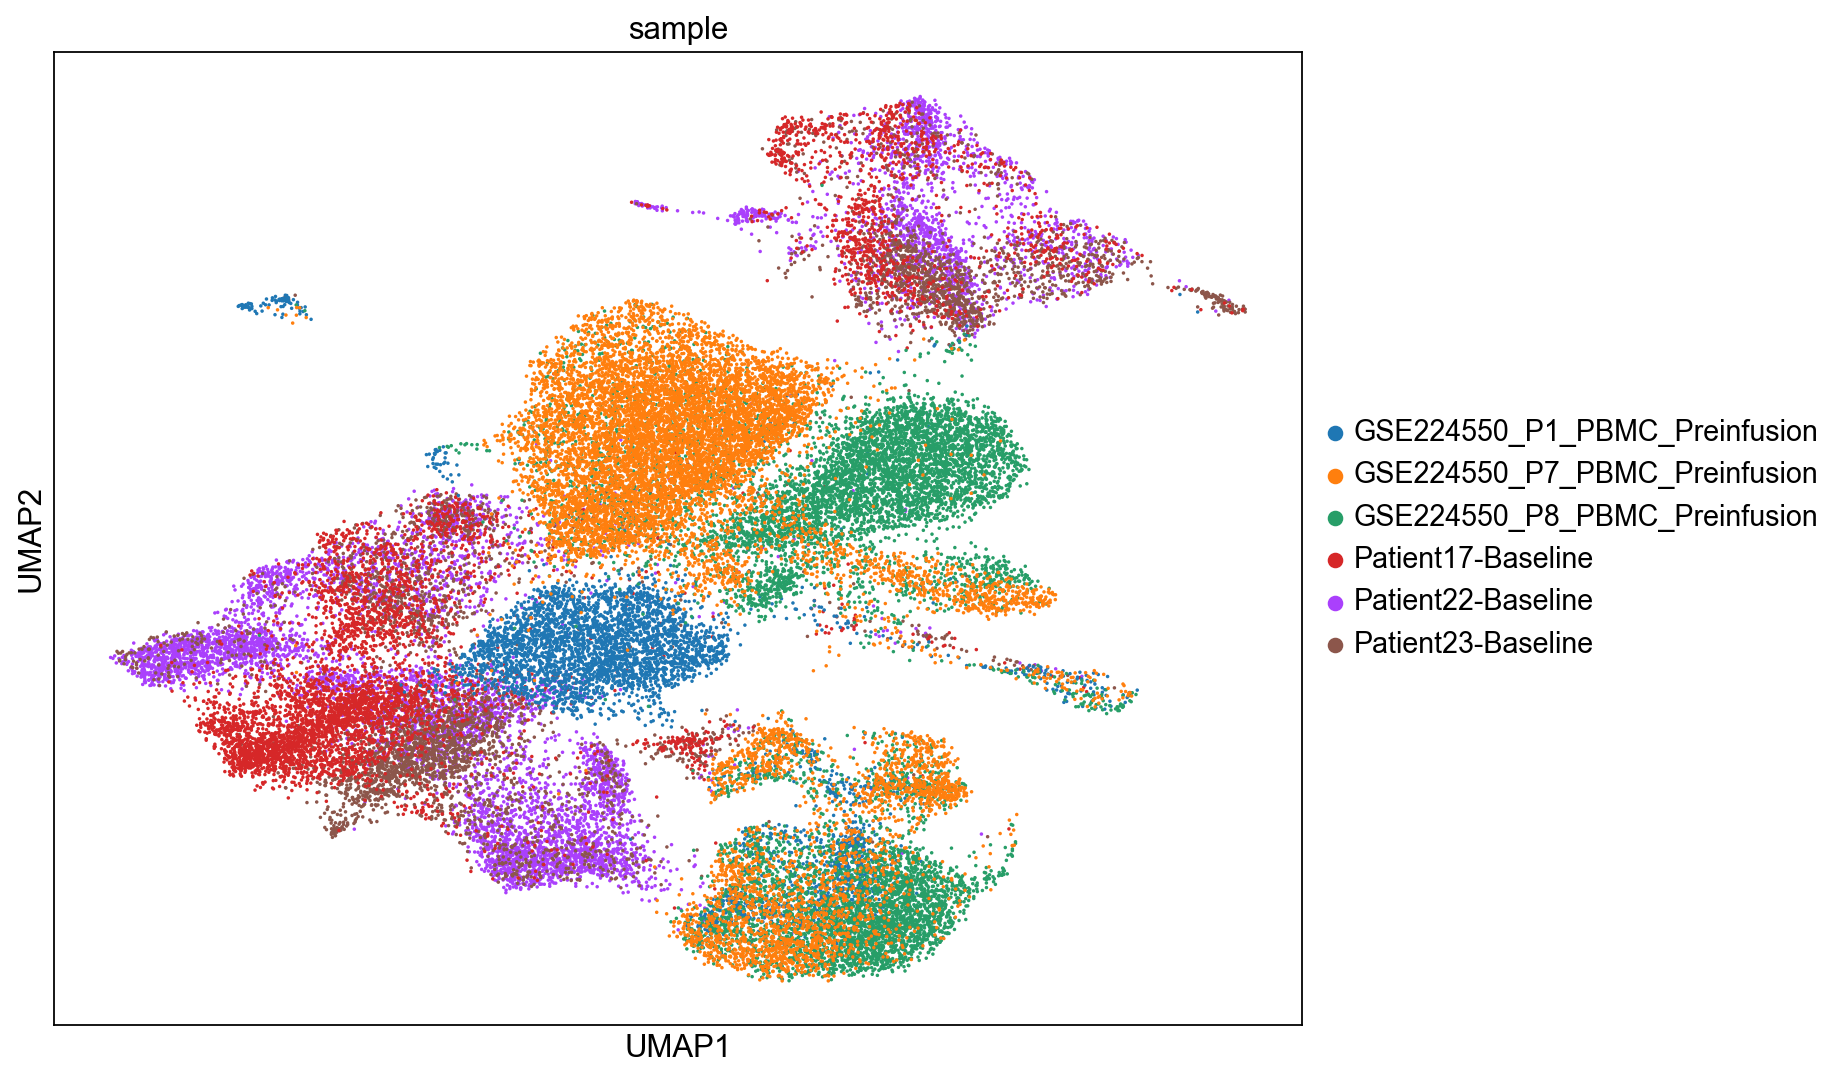

<Figure size 800x640 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)  # Adjust global figure size
sc.pl.umap(merged_adata, color="sample", size = 10)
plt.savefig("ScPre_UMAP_Plot.png", dpi=300, bbox_inches="tight")

In [34]:
merged_adata.write("Scanorama_unintegrated_Preinfusion.h5ad")